In [159]:
import jax.numpy as jnp
from jax import vmap, grad, value_and_grad
import jax
from jax import random

from tqdm import tqdm
import random as rand_np
import os
from scipy.io import mmread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import copy

from scipy.cluster.vq import kmeans2
np.set_printoptions(suppress = True)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

sc.settings.set_figure_params(dpi=80, facecolor='white')

## Cells with less than 20% overlapping neighbors can be removed as outliers. 

In [158]:
def read_data(cell_line):
    cell_line_mat = mmread(os.path.join(cell_line, "matrix.mtx"))
    genes = pd.read_csv(os.path.join(cell_line, "genes.tsv"), sep = "\t",header = None,names = ["gene_id", "something_else"] )
    barcodes = pd.read_csv(os.path.join(cell_line, "barcodes.tsv"), sep = "\t", header = None, names = ["barcodes"])
    df_line = pd.DataFrame(cell_line_mat.toarray(), columns= barcodes.barcodes, index = genes.gene_id).T
    
    return df_line, cell_line_mat, genes, barcodes

def get_adata_from_df(df, cell_line):

    adata = sc.AnnData(X = df, dtype = np.float32)
    adata.obs_names = df.index.values
    adata.var_names = df.columns.values
    adata.obs["cell_type"] = [cell_line for i in range(df.shape[0])]
    return adata

def do_qc(adata):
    """
    default qc recommended in pmbc3k tut scanpy
    """
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var['mt'] = adata.var_names.str.contains('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    adata = adata[adata.obs.n_genes_by_counts < 4000, :]
    adata = adata[adata.obs.pct_counts_mt < 5, :]
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata, max_value=10)
    print(adata)
    sc.tl.pca(adata, svd_solver='arpack',n_comps = 20)
    sc.pl.pca(adata, color='cell_type')
    return adata


def init_cluster_centers_kmeans(Z, n_clust = 5):

    """
    find cluster centers using kmeans and l2 norm the cluster centers 
    dimension is in first axis 
    
    """
    kmc, km_labels = kmeans2(Z, n_clust, minit='++')
    kmc = kmc.T
    kmc_norm = np.linalg.norm(kmc, ord = 2, axis = 0)

    kmc = kmc / kmc_norm
    return kmc, km_labels


def scale_pcs_cosine(adata):
    """
    scale principal components each individual data point is scaled by its max_feature value and then norm
    """
    X_pca = adata.obsm["X_pca"]
    X_pca = X_pca / X_pca.max(axis=1)[:, None]
    X_pca = X_pca / np.linalg.norm(X_pca, ord=2, axis=1)[:, None]
    adata.obsm["X_pca_cos"] = X_pca
    return adata

def stable_cross_entropy(x):
    ce = np.multiply(x,np.log(x))
    ce[~np.isfinite(ce)]  = 0.
    return ce




def compute_R(Z, Y, sigma_kernel = .1):
    dist_mat = -2*(1-np.dot(Z, Y)) 
    dist_mat = dist_mat / sigma_kernel
    dist_mat = dist_mat - dist_mat.max(axis = 1)[:, None]
    R = np.exp(dist_mat)
    R = R/R.sum(axis = 1)[:, None]
    return R



def init_parameters(Z, Y, adata, n_clust = 5, n_batch = 3, theta = 1 , sigma_penalty = .1 , sigma_kernel = .1):
    

    
    R = compute_R(Z, Y, sigma_kernel)
    
    
    batches, Nb = np.unique(adata.obs.cell_type.to_numpy(), return_counts = True)
    Prb = Nb/np.sum(Nb)
    E = np.outer(R.sum(axis = 0), Prb)

    
    enc = OneHotEncoder(categories = "auto")
    phi = enc.fit_transform(adata.obs.cell_type.to_numpy()[:, None]).toarray()

    O = np.dot(R.T, phi)
    
    tau = 0.
    theta_max = 100.
    if tau > 0:
        theta_penalty = theta_max * (1 - np.exp(-(Nb / (n_clust * tau)) ** 2))
    else:
        theta_penalty = theta*np.ones(n_batch)
    
    ### look into this ###
    
    dist_mat =  2*(1-np.dot(Z, Y)) 
    cost, cost_dic = compute_objective(dist_mat, R, phi, E, O, sigma_penalty, theta_penalty)
    
    return R, phi, Prb, E, O, theta_penalty, cost, cost_dic


def moe_regression( Z_orig, R, phi, lamb = 1., n_clust = 5):
    
    """
    checked
    """
    
    phi_aug = np.hstack([np.ones(phi.shape[0])[:, None], phi]) ### multiplying by diag(R_k) considers only those cells that are in cluster k, 
    Z_corr = copy.deepcopy(Z_orig)

    for k in tqdm(range(n_clust)):
        R_k = R[:, k][:, None]
        t1 = np.dot(phi_aug.T, np.multiply(R_k, phi_aug))
        I = np.eye(t1.shape[0])
        I[0, 0] = 0.
        ridge_penalty = lamb * I
        t1 = t1 + ridge_penalty
        t1_inv = np.linalg.inv(t1)
        t2 = np.dot(np.multiply(phi_aug, R_k), t1_inv)
        W = np.dot(Z_orig.T, t2)
        corr_term =  np.dot(W[...,1:], np.multiply(phi, R_k).T).T 
        Z_corr = Z_corr - corr_term

    Z = Z_corr / np.linalg.norm(Z_corr, ord=2, axis=1)[:, None]
    return Z, Z_corr, W

def cluster(Z, R, phi, E, O, Prb, sigma_penalty, theta_penalty, niters = 10, block_size = .05):
    
    cost_list = []
    cost_dic_list = []
    
    
    for ni in range(niters):
        
        Y = np.dot(Z.T, R)
        
        
        Y = Y / np.linalg.norm(Y, ord = 2, axis = 0)

        dist_mat = 2*(1-np.dot(Z, Y)) 
        
        update_order = np.arange(Z.shape[0])
        np.random.shuffle(update_order)
        n_blocks = np.ceil(1 / block_size).astype(int)
        blocks = np.array_split(update_order, n_blocks)
        ### update R ###
        R, E, O = update_R(Z, Y, R, phi, E, O, Prb, blocks, theta_penalty, sigma_penalty)

        cost, cost_dic = compute_objective(dist_mat, R, phi, E, O, sigma_penalty, theta_penalty)
        
        cost_list.append(cost)
        cost_dic_list.append(cost_dic)
    print (cost_list[-1], cost_dic_list[-1])
    return Z, R, phi, E, O, cost_list, cost_dic_list

## update R
def update_R( Z,Y,R, phi, E, O , Prb, permuted_blocks, theta_penalty, sigma_kernel ):
    
    """
    checked
    """
    
    dist_mat = -2*(1-np.dot(Z, Y)) 
    dist_mat = dist_mat / sigma_kernel
    dist_mat = dist_mat - dist_mat.max(axis = 1)[:, None]
    R_c = np.exp(dist_mat)
    
    
    for i, idx_in in enumerate(permuted_blocks):
        E = E - np.outer(R[idx_in,...].sum(axis = 0), Prb)
        O = O - np.dot(R[idx_in,...].T, phi[idx_in,...])
        
        
        R[idx_in,...] = R_c[idx_in,...]

        omega = np.power(((1+E)/(1+O)), theta_penalty).T
        omega_phi = np.dot( phi[idx_in, ...], omega) 
        
        R[idx_in,...] = np.multiply(R[idx_in,...], omega_phi  )
        
        ### is this wrong ###
        R[idx_in,...] = R[idx_in,...] / np.linalg.norm(R[idx_in,...],ord = 1,  axis = 1)[:, None]


        E = E + np.outer(R[idx_in,...].sum(axis = 0), Prb)
        O = O + np.dot(R[idx_in,...].T, phi[idx_in,...])
    
    return R, E, O

def compute_objective(dist_mat, R, phi, E, O, sigma_penalty, theta_penalty, n_clust = 5):
    
    kmeans_error = np.sum(np.multiply(R, dist_mat))
    cross_entropy_error = np.sum(stable_cross_entropy(R)*sigma_penalty)
    diversity_penalty = np.sum( np.multiply(R*sigma_penalty, np.dot(phi, (np.tile(theta_penalty[:,np.newaxis], n_clust).T * np.log((O + 1) / (E + 1))).T )))
    
    
    cost_dic = {"kmeans_err": kmeans_error, "ce": cross_entropy_error, "diversity_error": diversity_penalty}
    cost = kmeans_error+cross_entropy_error+diversity_penalty
    return cost, cost_dic 





In [ ]:
df_jkt,   jurkat,     _, _ = read_data("jurkat")
df_tcell, tcells,   _, _ = read_data("tcells")
df_mix,   mix_cells, _, _ = read_data("mix")

### perform qc steps on the data 

QC_steps - drop genes expressed in less than 3 cells , drop cells expressing less than 200 genes 

In [4]:
adata_jkt = get_adata_from_df(df_jkt, "jurkat")
adata_tcells = get_adata_from_df(df_tcell, "tcells")
adata_mix = get_adata_from_df(df_mix, "mix")

In [5]:
adata = sc.concat([adata_jkt, adata_tcells, adata_mix])

/home/user-dnf/anaconda3/envs/hiplex/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/user-dnf/anaconda3/envs/hiplex/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


filtered out 13861 genes that are detected in less than 3 cells


/home/user-dnf/anaconda3/envs/hiplex/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/user-dnf/anaconda3/envs/hiplex/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


/home/user-dnf/anaconda3/envs/hiplex/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 8201 × 18877
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mean', 'std'
    uns: 'log1p'
computing PCA
    with n_comps=20
    finished (0:00:02)


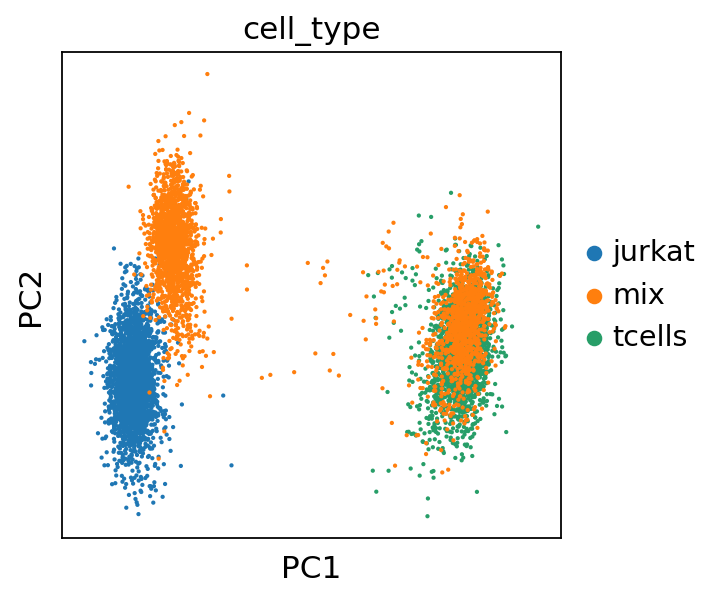

In [6]:
adata = do_qc(adata)

In [144]:
from tqdm import tqdm
import random as rand_np
import os
from scipy.io import mmread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
import copy

from scipy.cluster.vq import kmeans2
np.set_printoptions(suppress = True)

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)

sc.settings.set_figure_params(dpi=80, facecolor='white')


In [145]:
import harmony_mine as hm
import importlib
hm = importlib.reload(hm)

In [146]:
adata = sc.read_h5ad("test_data.h5ad")

/home/user-dnf/anaconda3/envs/hiplex/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [147]:
adata = scale_pcs_cosine(adata)
Z = adata.obsm["X_pca_cos"]
Z_orig = adata.obsm["X_pca"]
Z_cos = adata.obsm["X_pca_cos"]

In [148]:
n_clust = 5
sigma_penalty = .1*np.ones(3)
theta_penalty = np.ones(5)

In [149]:
Y, labels = hm.init_cluster_centers_kmeans(Z)

In [150]:
Yc = copy.deepcopy(Y)

In [151]:
color = adata.obs.cell_type
color = color.astype("category").cat.codes

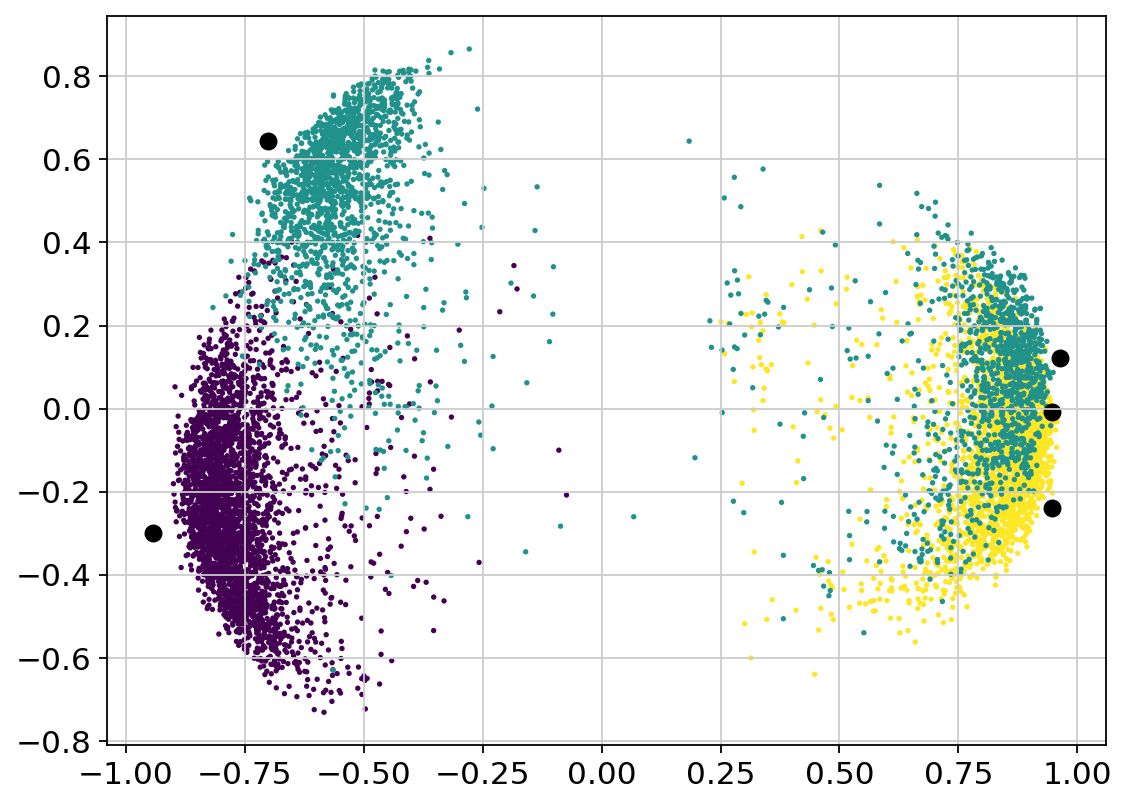

In [152]:
plt.figure(figsize =(8, 6))
plt.scatter(Z[..., 0], Z[..., 1], s = 2, c = color)
plt.scatter(Y[0, ...], Y[1, ...], s = 50, c = "k")

### compute cluster probabilities 

In [ ]:
### an advantage is that we can regress out on multiple variables at the same time with this approach

In [153]:
R, phi, Prb, E, O, theta_penalty, cost, cost_dic = hm.init_parameters(Z, Y, adata)

In [154]:
n_iters = 5
sigma_penalty = .1
block_size = 0.05

100%|██████████| 5/5 [00:00<00:00, 729.01it/s]


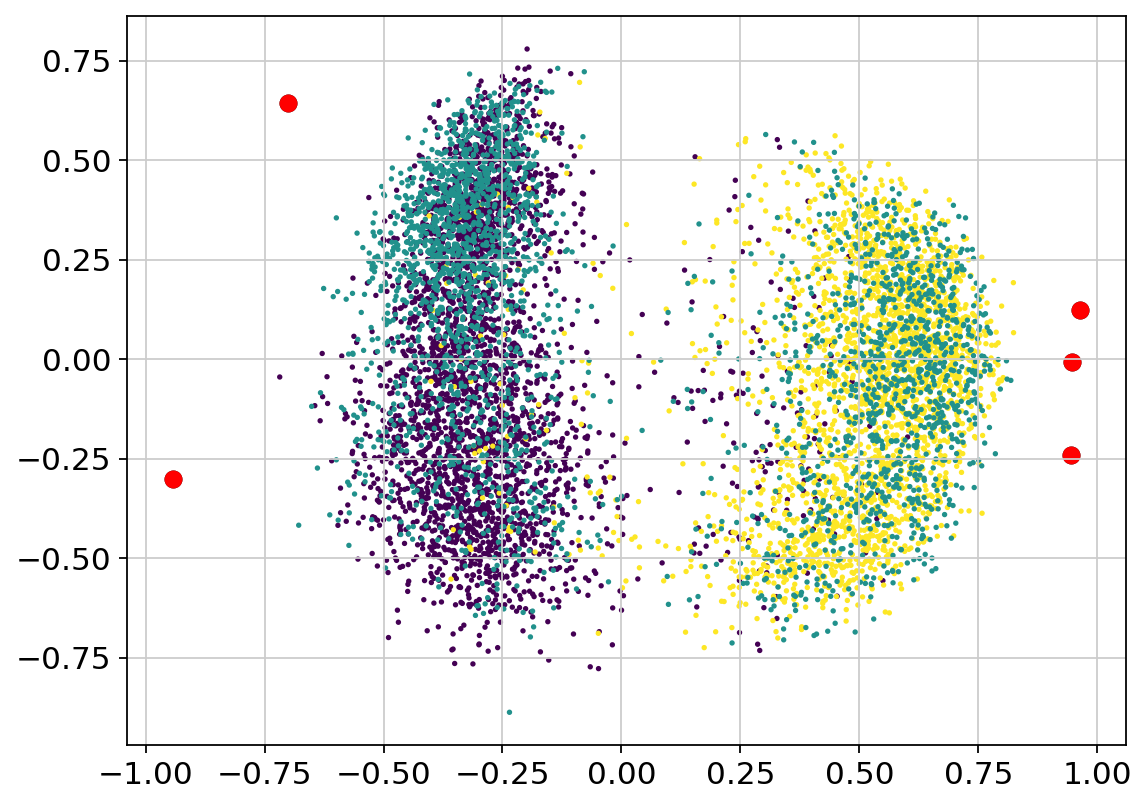

100%|██████████| 5/5 [00:00<00:00, 996.32it/s]


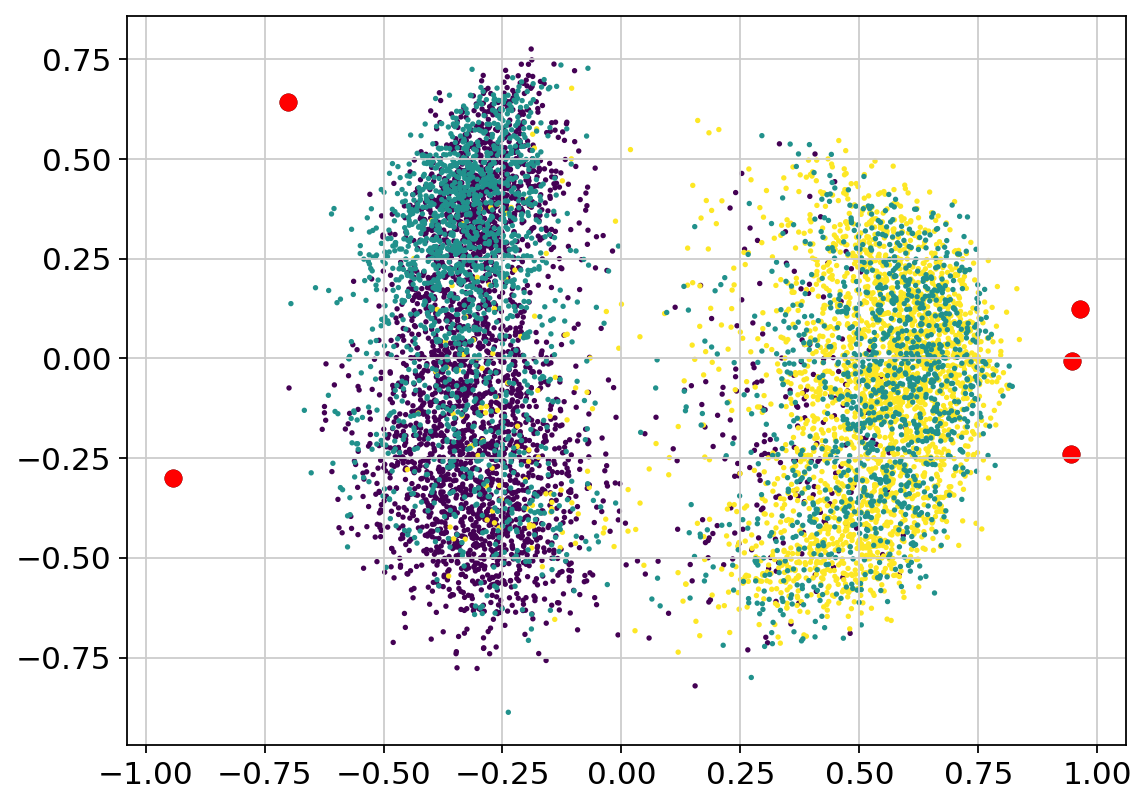

-0.026014491158521183


100%|██████████| 5/5 [00:00<00:00, 914.67it/s]


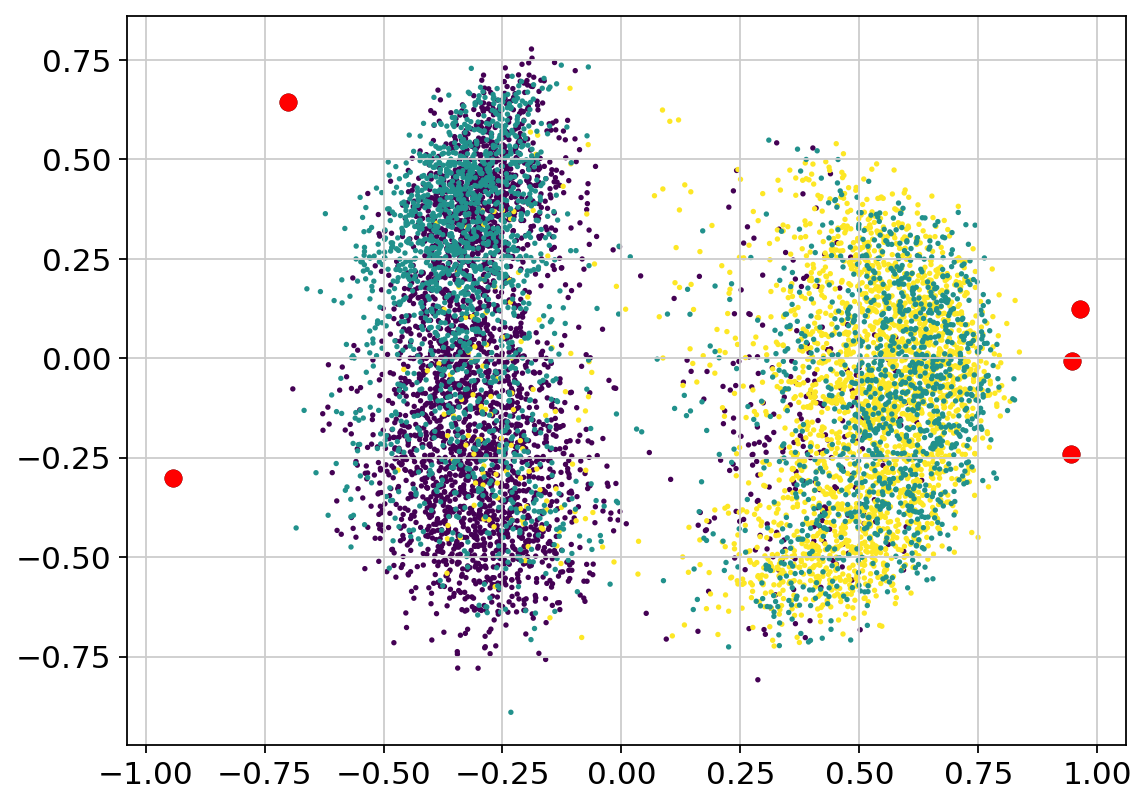

-0.01608406197626882


100%|██████████| 5/5 [00:00<00:00, 1027.97it/s]


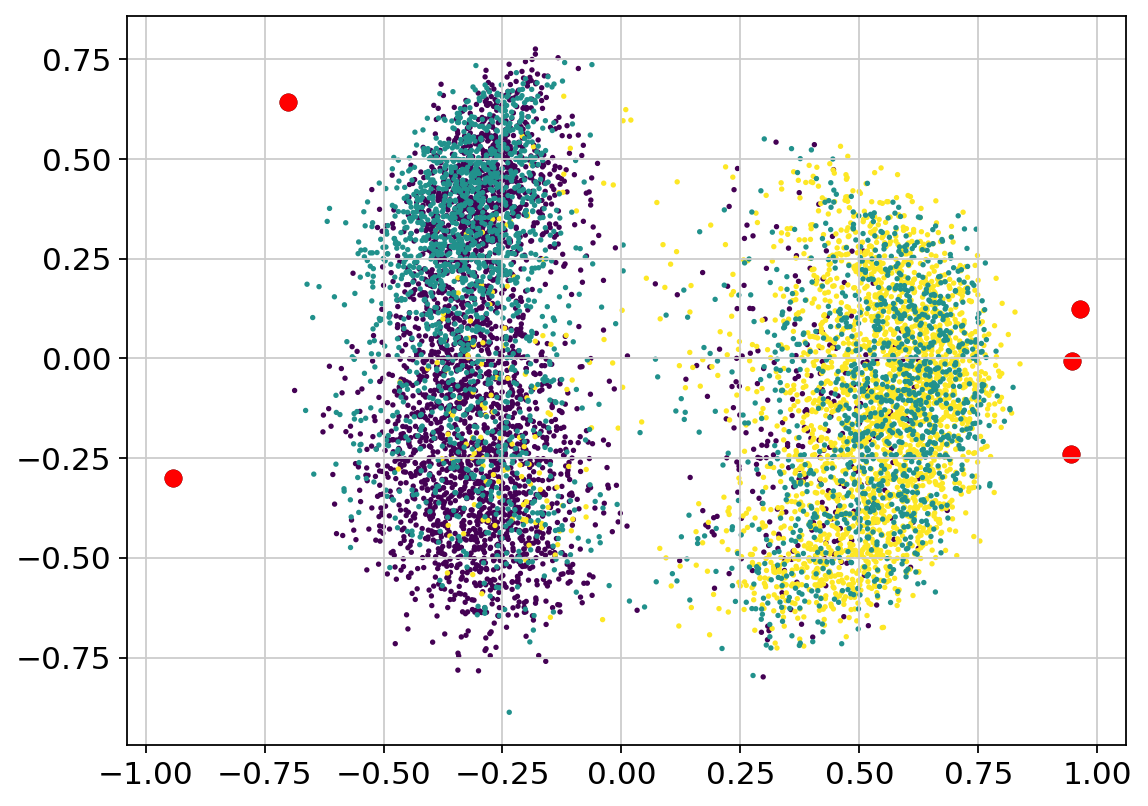

-0.010371403316753592


100%|██████████| 5/5 [00:00<00:00, 1037.63it/s]


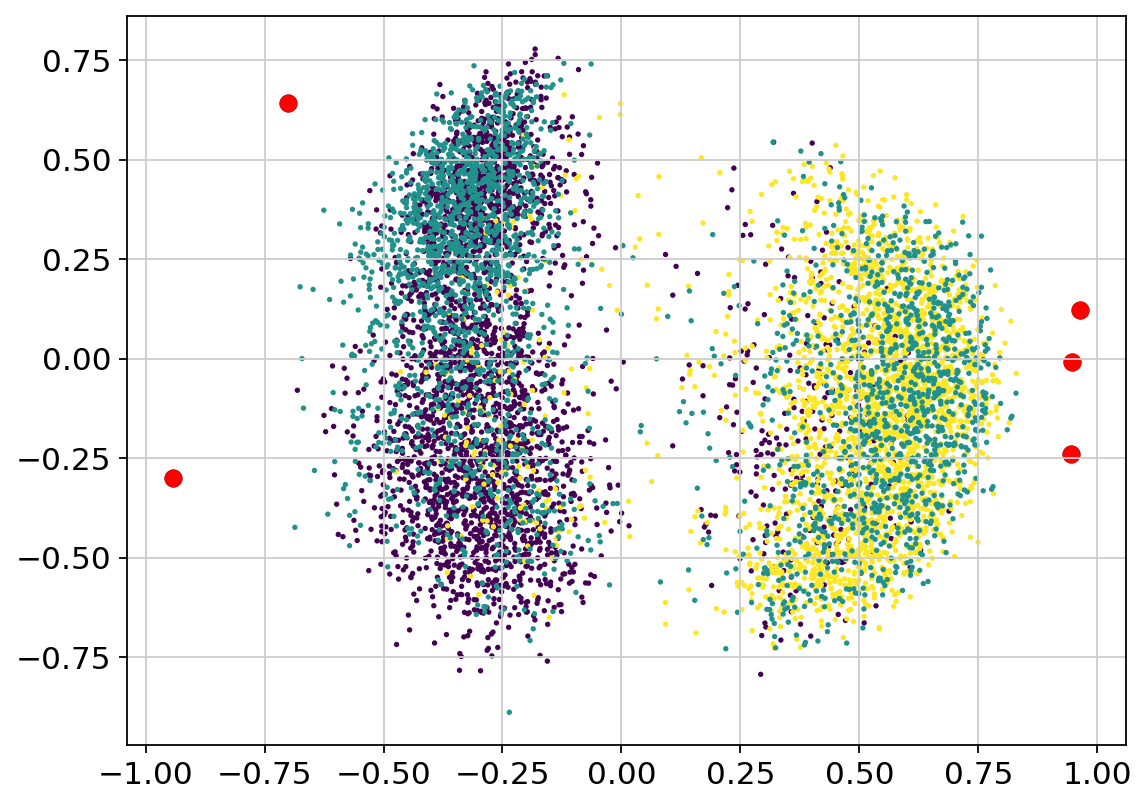

In [156]:
cost_list = []
harmony_error = []
for hk in range(5):
    
    

    Z, R, phi, E, O, cost_list, cost_dic_list = hm.cluster(Z, R, phi, E, O, Prb, sigma_penalty, theta_penalty, niters = 10, block_size = .05)
        
    harmony_error.append (cost_list[-1])
    
    if len(harmony_error) > 2:
        co = harmony_error[-2]
        cn = harmony_error[-1]
        eps = (co - cn)/abs(co)
        print (eps)
    
    
    
    Z, Z_corr, W = hm.moe_regression( Z_orig, R, phi, lamb = 1., n_clust = 5)
    
    plt.figure(figsize =(8, 6))
    plt.scatter(Z[..., 0], Z[..., 1], s = 2, c = color)
    plt.scatter(Y[0, ...], Y[1, ...], s = 50, c = "k")
    plt.scatter(Yc[0, ...], Yc[1, ...], s = 50, c = "r")
    plt.show()
    

In [160]:
W.shape

(20, 4)